# **Cars 4 You | Machine Learning Project**

### **Import Libraries**

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from rapidfuzz import process, fuzz
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from joblib import dump


### **Import Data**

In [339]:
df = pd.read_csv('../data/train.csv')

In [340]:
df_models = pd.read_csv('../data/car_models.csv')

---

### **Data Understanding**

In [341]:
df.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [342]:
df.describe(include='all')

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74452,74456,74482.000000,75973.000000,74451,74510.000000,74462,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
unique,NaN,72,735,NaN,NaN,40,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ford,Focus,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,14808,6353,NaN,NaN,38050,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN
mean,37986.000000,NaN,NaN,2017.096611,16881.889553,NaN,23004.184088,NaN,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,NaN,NaN,2.208704,9736.926322,NaN,22129.788366,NaN,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,NaN,NaN,1970.000000,450.000000,NaN,-58540.574478,NaN,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,NaN,NaN,2016.000000,10200.000000,NaN,7423.250000,NaN,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,NaN,NaN,2017.000000,14699.000000,NaN,17300.000000,NaN,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,NaN,NaN,2019.000000,20950.000000,NaN,32427.500000,NaN,145.000000,62.800000,2.000000,82.000000,3.000000,0.0


#### **Data Quality**
- **Price**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a slightly left skewed distribution
- **Mileage**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a left skewed distribution, we also have negative values, so we need to handle these values
- **Tax**: we have negative values, we need to investigate why these values are negative and If they make any sense in this context
- **MPG**: We have negative values, we need to handle these values
- **Engine Size**: We have negative values, needing to handle them
- **PaintQuality%**: We have values above 100%, we need to check this cases and see if they make any kind of sense
- **previousOwners**: We have negative and float values, we need to handle this cases as well
- **hasDamage**: Seems like a constant value feature, we need to check if thats the case


In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [344]:
df['transmission'].unique()

array(['Semi-Auto', 'Manual', 'anual', 'Semi-Aut', 'Automatic', 'manual',
       nan, 'unknown', 'Manua', 'AUTOMATIC', 'MANUAL', 'semi-auto',
       ' Manual ', 'automatic', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT',
       'Automati', 'ANUAL', 'utomatic', 'unknow', 'EMI-AUTO', 'manua',
       'anua', 'emi-Aut', 'MANUA', 'emi-auto', 'UTOMATIC', ' manual ',
       ' MANUAL ', 'UNKNOWN', 'nknown', 'automati', 'Other', 'semi-aut',
       ' Manual', 'AUTOMATI', 'utomati', 'Manual ', 'manual ', 'nknow'],
      dtype=object)

In [345]:
df['fuelType'].unique()

array(['Petrol', 'Diesel', 'etrol', 'Hybrid', 'diesel', 'iesel', nan,
       'petrol', 'PETROL', 'Diese', 'Petro', 'DIESEL', 'petro', 'HYBRID',
       'ybri', 'Other', 'DIESE', 'Hybri', 'ETROL', 'ybrid', 'PETRO',
       'hybrid', 'IESEL', 'Electric', 'ther', 'iese', 'etro', 'ETRO',
       'diese', 'Othe', 'YBRID', 'HYBRI', 'OTHER', 'other', 'IESE'],
      dtype=object)

we have lots of typos in here, we need to fix this later on

---

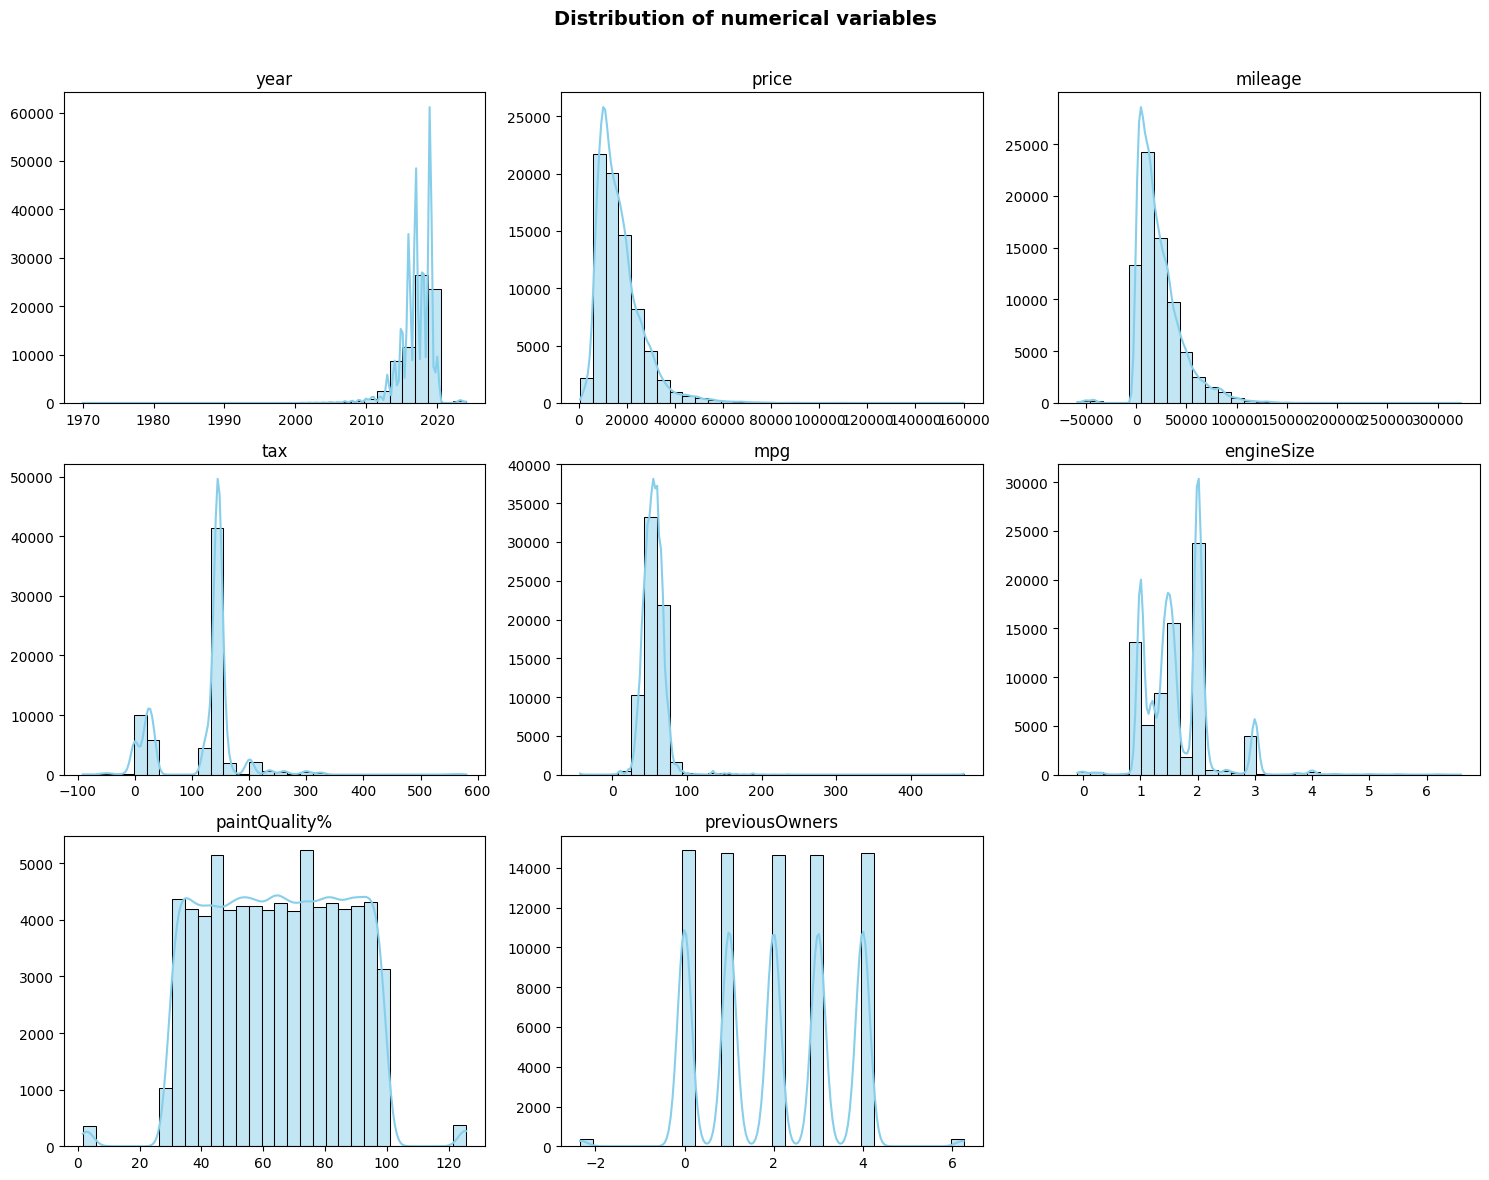

In [346]:
num_cols = [c for c in ['year','price','mileage','tax','mpg','engineSize','paintQuality%','previousOwners'] if c in df.columns]

n = len(num_cols)
ncols = 3  # number of graphics per row
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

#remove empty axes (if number of plots is not a multiple of ncols)--» otherwise there would be an empty graph in the third line
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of numerical variables", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

| Variable | Distribution | Key Range | Insights |
|----------|--------------|-----------|--------------|
| **Year** | Peaked around recent years | 2000-2024<br>*(Mostly 2016-2020)* | Modern cars dominate<br>Create "age" feature for depreciation |
| **Price** | Right-skewed | €500 - €160k<br>*(Mostly 10k-€20k€)* | Log transformation <br>High-end outliers present |
| **Mileage** | Right-skewed | 0 - 300k km<br>*(Mostly 0-40k km)* | Negative correlation with price expected<br>Logical after cleaning |
| **Tax** | Highly right-skewed | 0 - 600<br>*(Mostly 150-200)* | Validate low/zero values<br>Standard tax brackets dominate |
| **MPG** | Right-skewed | 0 - 450<br>*(Mostly 40-80 MPG)* | Extreme values likely errors<br>Log transformation could help |
| **Engine Size** | Multiple peaks | 0 - 6.5L<br>*(Peaks at 1.0, 1.6, 2.0L)* | Positive price correlation expected<br>Reflects vehicle class mix |
| **Paint Quality** | Nearly uniform | 0 - 120<br>*(Expected 0-100)* | Limited predictive power<br>Values >100 likely errors |
| **Previous Owners** | Discrete, multi-peaked | 0 - 6<br>*(Mostly 0-4)* | More owners may lower price<br>Effect likely moderate |

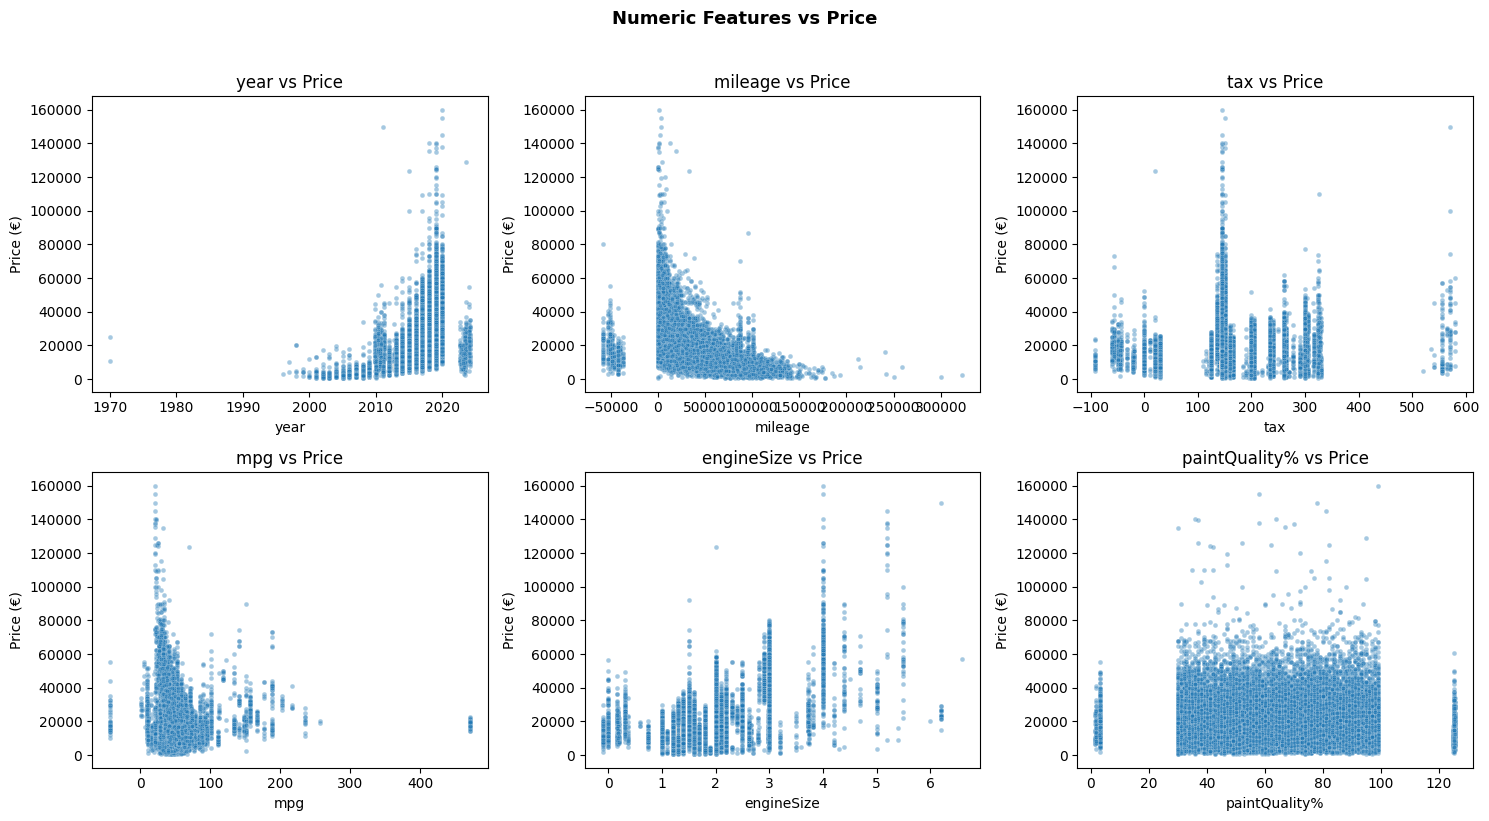

<Figure size 640x480 with 0 Axes>

In [347]:
# List of the numerical features
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']

# Scatterplots for all the numerical features except "previous_owners" because it doesn´t make sense to use scaterplott in this variable
others = [c for c in num_cols if c not in ['price', 'previousOwners']]
n, ncols = len(others), 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, others):
    sns.scatterplot(data=df, x=col, y='price', alpha=0.4, s=12, ax=ax)
    ax.set_title(f"{col} vs Price")
    ax.set_xlabel(col)
    ax.set_ylabel("Price (€)")

# Remove eixos vazios se existirem
for j in range(len(others), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numeric Features vs Price", y=1.02, fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
plt.tight_layout(); plt.show()

| Feature vs Price | Relationship | Key Pattern 
|------------------|--------------|-------------|
| **Year → Price** | Strong positive | Newer cars are more expensive; vertical banding by year feature |
| **Mileage → Price** | Strong negative | Non-linear: steep drop at low mileage, flattens later curve |
| **Engine Size → Price** | Positive but noisy | Vertical stripes at common sizes (1.0, 1.6, 2.0L) |
| **MPG → Price** | Weak/ambiguous | Hints of negative trend; efficient cars often cheaper |
| **Tax → Price** | No clear trend | Clusters in regulatory bands |
| **Paint Quality → Price** | No visible trend | Near-uniform vertical spread |

---

## **Data Preparation**

#### **Checking for constant value features**

In [348]:
# check for constant values features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant features: {constant_features}')

Constant features: ['hasDamage']


Since hasDamage is a constant feature, we can safely remove it since theres no meaning if its keeped

In [349]:
df= df.drop(columns='hasDamage')

### **Flag zero values in engineSize**

we detected that we had engine sizes under 1, wich is not possible, we will set these values to nan and later fill them with knn

In [350]:
df[df['engineSize']<=0.99]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
50,61006,Opel,Corsa,2019.0,9995,Manual,4366.0,Petrol,150.0,43.5,0.739534,66.0,3.0
64,30317,Ford,NaN,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.000000,61.0,3.0
443,24113,Ford,Kuga,NaN,14950,Manual,13411.0,Diesel,125.0,60.1,-0.103493,83.0,1.0
737,3840,Audi,NaN,2019.0,21262,Manual,4868.0,Diesel,145.0,49.6,0.154529,58.0,2.0
759,21935,Ford,KA,2018.0,8444,Manual,17000.0,Petrol,145.0,57.7,0.000000,51.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75476,46732,Skoda,Octavi,2018.0,11290,Manual,20047.0,Petrol,145.0,58.9,0.191462,98.0,0.0
75559,38494,Mercedes,GLA Class,2016.0,19498,Semi-Auto,27846.0,DIESEL,125.0,56.5,0.307074,89.0,4.0
75753,59040,Opel,Grandland X,2019.0,17289,Manual,14421.0,Diesel,145.0,56.5,0.739534,74.0,0.0
75874,70592,VW,Caddy Maxi,2015.0,9995,Semi-Auto,66000.0,DIESEL,200.0,48.7,0.186425,34.0,3.0


In [351]:
# set engine size to nan where it is 0
df.loc[df['engineSize'] <= 0.99, 'engineSize'] = np.nan

#### **Dealing with missing values**

First, lets check if we have any entries with every feature missing

In [352]:
# create a mask for rows where all columns except 'carID' and 'price' are NaN
mask = df.drop(columns=['carID', 'price']).isna().all(axis=1)
df_missing_rows = df[mask]

df_missing_rows.size

0

We don't have any row that is completely null

##### **Let's now check the percentages of missing values for each column**

In [353]:
# check the percentage of missing values for each column
missing_percent = df.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
df_missing_percent = pd.DataFrame({'column': missing_percent.index, 'missing_percent': missing_percent.values})
df_missing_percent

,column,missing_percent
0,mpg,10.432654
1,tax,10.403696
2,engineSize,2.750977
3,previousOwners,2.040198
4,paintQuality%,2.005976
5,transmission,2.003343
6,Brand,2.002027
7,model,1.996762
8,fuelType,1.988864
9,year,1.962539


We have some percentage of missing values but nothing too bad.

#### **Fill Missing Values in Numeric Features**

For the numeric features, we will use KNN imputation with the 5 nearest neighbors and just set the weights to 'uniform'.

In [354]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

In [355]:
# store mean and std
means = df[num_cols].mean()
stds = df[num_cols].std()

# normalize
df_scaled = (df[num_cols] - means) / stds

# impute on scaled data
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=num_cols,
    index=df.index
)

# inverse transform
df[num_cols] = df_imputed_scaled * stds + means

#### **Fill Missing Values in Categorical Features**

For the categorical variables we will use a Random Forest Classifier.  
We will train this RFC with the non null entries and use them to predict the null entries.  
We will do this sequentially in this order:  
Brand -> Model -> fuelType -> transmission

Since we believe thats the feature importance order.

In [356]:
def train_impute_rfc(train_df, target_col, ignore_cols=['carID','price'], n_estimators=200, model_path="assets/rfc_model.joblib"):
    """
    Treina um Random Forest para imputar valores missing em target_col do train_df,
    preenche os missing no train_df e salva o modelo e as colunas do treino em .joblib.

    Returns:
        train_df: DataFrame com target_col imputado
        rfc: modelo treinado
        X_train_cols: colunas do treino
    """
    df_notnull = train_df[train_df[target_col].notnull()]
    df_null = train_df[train_df[target_col].isnull()]
    
    predictors = train_df.columns.drop([target_col] + ignore_cols)
    
    X_train = pd.get_dummies(df_notnull[predictors], drop_first=True)
    y_train = df_notnull[target_col]
    
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    # Imputar missing no train
    if not df_null.empty:
        X_null = pd.get_dummies(df_null[predictors], drop_first=True)
        X_null = X_null.reindex(columns=X_train.columns, fill_value=0)
        train_df.loc[df_null.index, target_col] = rfc.predict(X_null)
    
    print(f"Train: Imputed '{target_col}' with {len(df_null)} missing values")
    
    # salvar modelo e colunas
    dump(rfc, model_path)
    dump(X_train.columns, model_path.replace(".joblib","_cols.joblib"))
    
    return train_df, rfc, X_train.columns

In [357]:
'''cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

for col in cat_cols:
    df, rfc_model, columns = train_impute_rfc(df, target_col=col)'''
    


"cat_cols = ['Brand', 'model', 'fuelType', 'transmission']\n\nfor col in cat_cols:\n    df, rfc_model, columns = train_impute_rfc(df, target_col=col)"

In [358]:
# save the filled dataframe to a csv file
#df.to_csv('../data/filled_cars.csv', index=False)

In [359]:
df = pd.read_csv('../data/filled_cars.csv')

In [360]:
df.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,102.333851,11.417268,2.0,63.0,4.000000
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.000000,47.900000,1.5,50.0,1.000000
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.000000,40.900000,1.5,56.0,4.000000
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.000000,65.700000,1.0,50.0,-2.340306
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.000000,42.800000,1.5,97.0,3.000000


---

### **Data Consistency**

In [361]:
#We noticed that some values of paintQuality% are higher than 100%, so we decided to assume that it's value is 100%
df.loc[df['paintQuality%'] > 100, 'paintQuality%'] = 100

In [362]:
columns_negative= ["previousOwners","mileage","mpg","engineSize","tax"]

# Apply abs function to each column in columns_negative
for col in columns_negative:
    df[col] = df[col].abs()

In [363]:
df[['mileage','paintQuality%','year','previousOwners']] = (
    df[['mileage','paintQuality%','year','previousOwners']]
    .round()
    .astype('Int64')
)

In [364]:
df[['tax', 'mpg']] = df[['tax', 'mpg']].round(2)

In [365]:
df[['engineSize']] = df[['engineSize']].round(1)


**fixing brand and model typos**

In [366]:
# normalize strings: strip, lower
def clean_text(s):
    if pd.isna(s):
        return ''
    return str(s).strip().lower()


# standard values in model
def standardize_model(s):
    if pd.isna(s):
        return ''
    s = str(s).lower().strip()
    s = s.replace('-', ' ')
    s = ' '.join(s.split())
    return s

def safe_extract_one(query, choices, scorer):
    result = process.extractOne(query, choices, scorer=scorer)
    if result is None:
        return None, 0
    # Algumas versões retornam 2 valores, outras 3
    if len(result) == 2:
        match, score = result
    elif len(result) == 3:
        match, score, _ = result
    else:
        match, score = result[0], result[1]
    return match, score


def correct_brand(row, df_models):
    brand = row['brand_clean']
    model = row['model_fixed']

    # Filtra todas as marcas possíveis para este modelo
    matching_brands = df_models[df_models['model_clean'] == model]['brand_clean'].unique()

    if len(matching_brands) == 1:
        # Se existe apenas 1 marca para o modelo, força essa marca
        return matching_brands[0]
    elif len(matching_brands) > 1:
        # Se houver várias marcas (estranho, mas possível), escolhe a mais frequente
        return max(set(matching_brands), key=list(matching_brands).count)
    
    # Se o modelo não existe, fallback para original ou fuzzy
    if brand in df_models['brand_clean'].values:
        return brand

    all_brands = df_models['brand_clean'].unique()
    matched_brand, score = safe_extract_one(brand, all_brands, scorer=fuzz.token_sort_ratio)
    return matched_brand if score >= 40 else brand


# --- fix models ---
def correct_model(row, df_models):
    model = row['model_clean']
    brand = row['brand_clean']
    
    if ((df_models['brand_clean'] == brand) & (df_models['model_clean'] == model)).any():
        return model
    
    if brand in df_models['brand_clean'].values:
        possible_models = df_models[df_models['brand_clean']==brand]['model_clean'].tolist()
        matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
        return matched_model if score >= 40 else model
    
    possible_models = df_models['model_clean'].tolist()
    matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
    return matched_model if score >= 40 else model

In [367]:
# standardize
df['brand_clean'] = df['Brand'].apply(clean_text)
df['model_clean'] = df['model'].apply(clean_text)
df_models['brand_clean'] = df_models['brand'].apply(clean_text)
df_models['model_clean'] = df_models['model'].apply(clean_text)

# apply fix functions
df['model_fixed'] = df.apply(correct_model, axis=1, df_models=df_models)
df['brand_fixed'] = df.apply(correct_brand, axis=1, df_models=df_models)

df_compare= df.copy()
# drop columns brand clean, model_clean, brand, model
df.drop(columns=['brand_clean', 'model_clean', 'Brand', 'model'], inplace= True)

df = df.rename(columns={'brand_fixed': 'brand', 'model_fixed': 'model'})

In [368]:
# --- etapa final: harmonizar modelos com marcas divergentes ---
freqs = df.groupby(['model', 'brand']).size().reset_index(name='count')

# para cada modelo, ver se há mais de uma marca associada
for model, group in freqs.groupby('model'):
    if len(group) > 1:
        total = group['count'].sum()
        group = group.sort_values('count', ascending=False)
        major_brand, major_count = group.iloc[0]['brand'], group.iloc[0]['count']
        ratio_major = major_count / total

        # se maioria tiver mais de 60% das ocorrências → força
        if ratio_major >= 0.6:
            minor_brands = group.iloc[1:]['brand'].tolist()
            df.loc[(df['model'] == model) & (df['brand'].isin(minor_brands)), 'brand'] = major_brand

**fixing fuel type and transmission typos**

In [369]:
# Canonical values of fuel_type and transmission
canonical_fuels = ['petrol', 'diesel', 'hybrid', 'electric', 'other']
canonical_transmissions = ['manual', 'automatic', 'semi-auto', 'other']

# Normalize column strings
df['fuel_type_clean'] = (df['fuelType']
    .astype(str)
    .str.strip()
    .str.lower()
)
df['transmission_clean'] = (df['transmission']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Correcting typos in the columns
def fuzzy_match_column(series, canonical_values, score_cutoff=85, default='other'):
    """
    Fuzzy-matches each value in a pandas Series to a list of canonical values.
    Example:
        fuzzy_match_column(df['fuel_type_clean'], ['petrol', 'diesel', 'electric'])
    """
    def match_one(value):


        # exact match
        if value in canonical_values:
            return value

        # fuzzy match
        match = process.extractOne(value, canonical_values, scorer=fuzz.token_sort_ratio)
        if match is None:
            return "unknown"

        best_choice, score, _ = match
        return best_choice if score >= score_cutoff else default

    return series.apply(match_one)


# apply fix functions
df['fuel_type_fixed'] = fuzzy_match_column(df['fuel_type_clean'], canonical_fuels)
df['transmission_fixed'] = fuzzy_match_column(df['transmission_clean'], canonical_transmissions)


# final result
df[['fuelType', 'fuel_type_clean', 'fuel_type_fixed',
    'transmission', 'transmission_clean', 'transmission_fixed']].head(10)


# drop and rename
df.drop(columns= ['fuelType', 'fuel_type_clean', 'transmission','transmission_clean'], inplace= True)

df = df.rename(columns={'fuel_type_fixed': 'fuel_type', 'transmission_fixed': 'transmission'})

In [370]:
# save df for later test in df test
df.to_csv('../data/df_fixed_typos.csv', index=False)


### **Duplicates**

First thing first, lets check if we have duplicate ids

In [371]:
df['carID'][df['carID'].duplicated()]

Series([], Name: carID, dtype: int64)

AS we see, theres no duplicated ids

In [372]:
df[df.duplicated(keep=False)]

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model,brand,fuel_type,transmission


No duplicated rows as well

### **Fix Column Names**

In [373]:
# change order of columns
df = df[['carID','brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']]

In [374]:
# rename column cardid to car_id and brand fixed to brand
df = df.rename(columns={'carID': 'car_id', 'engineSize': 'engine_size', 'paintQuality%': 'paint_quality', 'previousOwners': 'previous_owners'})

In [375]:
df.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
0,69512,volkswagen,golf,2016,semi-auto,28421,petrol,102.33,11.42,2.0,63,4,22290
1,53000,toyota,yaris,2019,manual,4589,petrol,145.00,47.90,1.5,50,1,13790
2,6366,audi,q3,2019,semi-auto,3624,petrol,145.00,40.90,1.5,56,4,24990
3,29021,ford,fiesta,2018,manual,9102,petrol,145.00,65.70,1.0,50,2,12500
4,10062,bmw,2 series,2019,manual,1000,petrol,145.00,42.80,1.5,97,3,22995


---

## **More EDA**

C:\Users\vehnie\AppData\Local\Temp\ipykernel_8392\4190273431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])
C:\Users\vehnie\AppData\Local\Temp\ipykernel_8392\4190273431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])


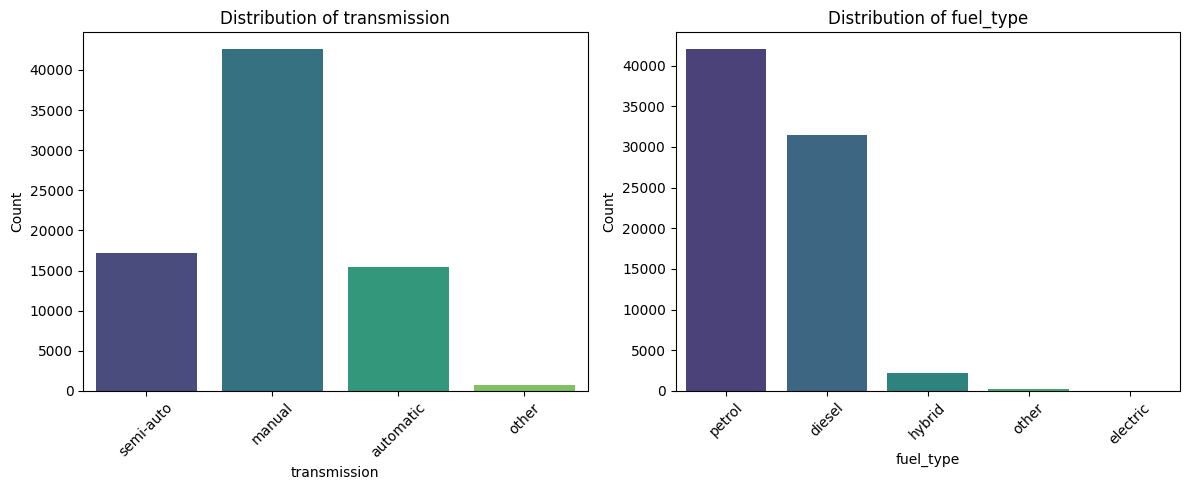

In [376]:
cat_features = ['transmission', 'fuel_type']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for i, col in enumerate(cat_features):
    sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


We will set 'other' as NaN values and fill it again with the RFC model.  
For the fuel_type, we will merge the 'hybrid' and 'electric' to 'other' 

---

## **Outliers**

### **Bi-variate Analysis**

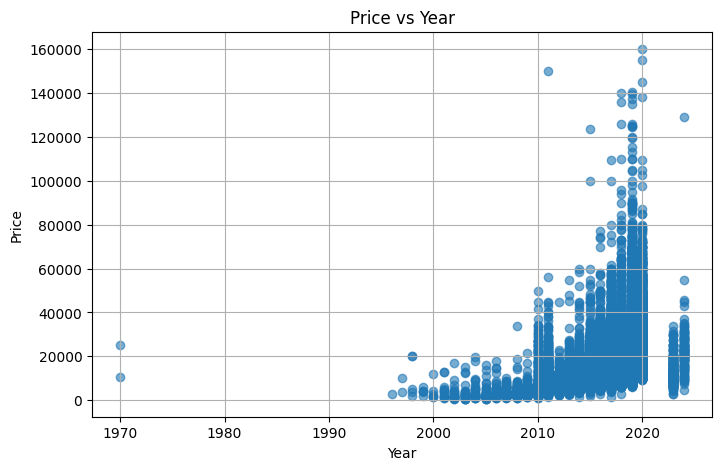

In [377]:
plt.figure(figsize=(8,5))
plt.scatter(df['year'], df['price'], alpha=0.6)
plt.title('Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**Price vs year**  
- newer cars (2016–2024) have much higher prices and wider spread, wwhich's normal
- older cars (before 2005) - a few have prices above £20,000–£40,000, but most of them are concentrated at price under £20,000
- **Drop cars with year < 1990 as this value doesn't make sense**

In [378]:
# drop cars with year < 1990
df = df[df['year'] >= 1990]

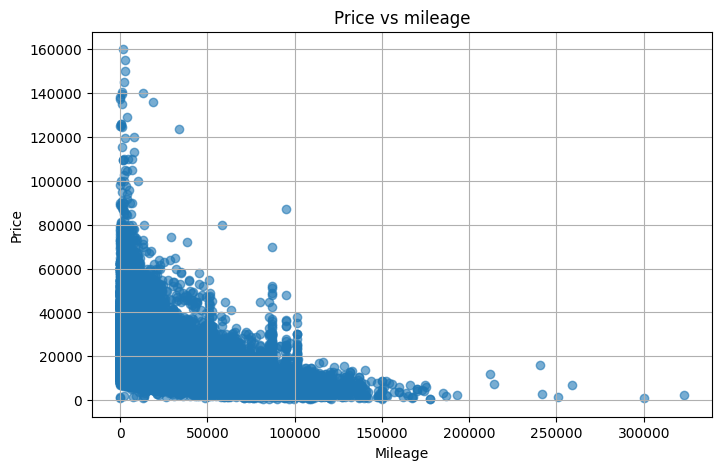

In [379]:
plt.figure(figsize=(8,5))
plt.scatter(df['mileage'], df['price'], alpha=0.6)
plt.title('Price vs mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**Price vs mileage**
- negative correlation - higher mileage = lower price.
- A few low-mileage cars with very low prices - quite reasonable prices for the models, high prices - better and newer cars
- A few high-mileage cars (>200,000–250,000 km) still make sense as price is reasonably low for them

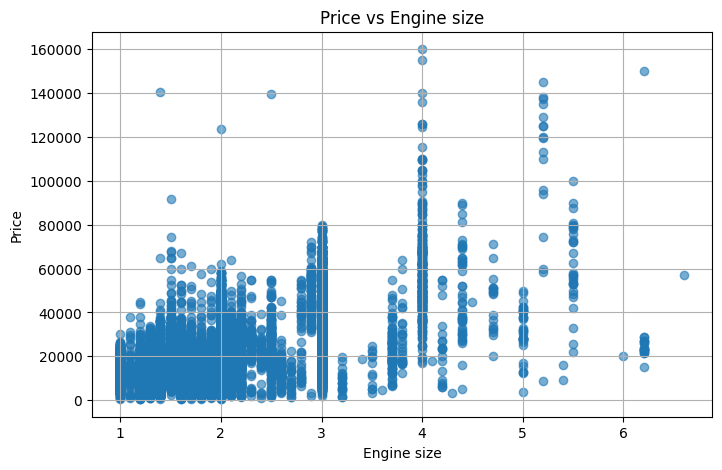

In [380]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['price'], alpha=0.6)
plt.title('Price vs Engine size')
plt.xlabel('Engine size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [381]:
# Show cars that are too expensive for small engines
print("Cars with price > 120000 and engine_size < 3.0:")
display(df[(df["price"] > 120000) & (df["engine_size"] < 3.0)])

# Show cars that are too cheap for big engines
print("\nCars with engine_size > 5.0 and price < 25000:")
display(df[(df["engine_size"] > 5.0) & (df["price"] < 25000)])

Cars with price > 120000 and engine_size < 3.0:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
15364,41265,mercedes,a-class,2019,semi-auto,1000,petrol,145.0,22.1,2.5,37,4,139559
34018,43994,mercedes,a-class,2019,semi-auto,785,petrol,150.0,22.1,1.4,64,0,140319
44022,13374,bmw,2 series,2015,semi-auto,33419,diesel,20.0,68.9,2.0,42,3,123456



Cars with engine_size > 5.0 and price < 25000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4049,38980,mercedes,c-class,2013,semi-auto,43442,petrol,165.00,52.44,6.2,76,0,23000
5047,46372,mercedes,c-class,2013,semi-auto,49964,petrol,397.21,23.00,6.2,78,3,22995
14216,35612,mercedes,c-class,2013,automatic,48618,petrol,570.00,23.50,6.2,44,2,23990
20432,35538,mercedes,c-class,2015,semi-auto,49964,petrol,326.03,34.12,6.2,58,3,22995
20916,44937,mercedes,c-class,2013,automatic,41866,petrol,570.00,23.50,6.2,80,0,21999
23239,3167,audi,a6,2006,automatic,98000,petrol,570.00,21.10,5.2,93,0,8750
24327,46536,mercedes,c-class,2013,automatic,44000,petrol,202.00,128.50,6.2,88,2,23990
29612,45353,mercedes,cl-class,2002,automatic,77000,petrol,325.00,21.10,5.4,42,2,8995
39475,37825,mercedes,e-class,2008,semi-auto,55000,petrol,570.00,19.80,6.2,70,1,14995
41101,40094,mercedes,c-class,2013,automatic,39000,petrol,392.00,29.02,6.2,89,1,22948


**Price vs Engine Size**
- As we can see for cars with engine size <3 price is unreasonably high, as a normal price for these cars is around 20-30000
- Also cars with too high engine size aren't within normal range as normally cars of these models have 2-3L, but the price is quite normal
- We will also remove entries where engine size > 6, as these cars are very rare and don't make sense in a real world scenario
- **So, we will consider both of these categories as outliers as the values don't make sense ina real world**

In [382]:
# remove entries where engine size < 3 and price > 120000
df = df[(df['engine_size'] >= 3) | (df['price'] <= 120000)]

# remove entries where engine size > 5 and price < 25000
df = df[(df['engine_size'] <= 5) | (df['price'] >= 25000)]

# remove entries where engine size > 6
df = df[df['engine_size'] <= 6]


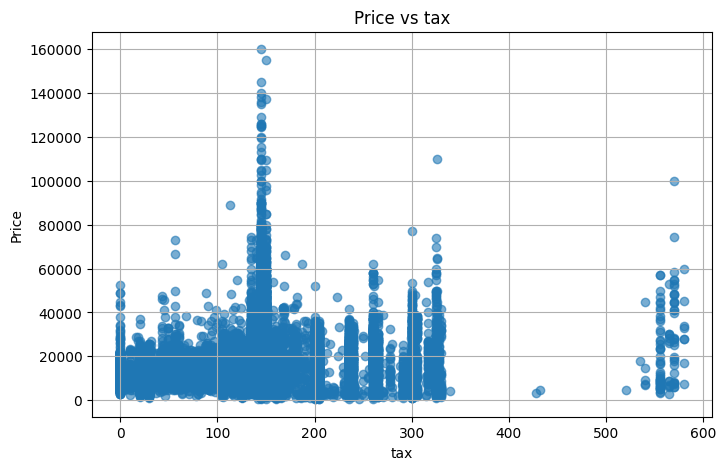

In [383]:
plt.figure(figsize=(8,5))
plt.scatter(df['tax'], df['price'], alpha=0.6)
plt.title('Price vs tax')
plt.xlabel('tax')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**Price vs tax**
- We can see some outliers that sit under the 300 and 500 tax range, where that range is not common for most cars

In [384]:
# remove entries where tax is in the range of 350 and 500
df = df[(df['tax'] < 350) | (df['tax'] > 500)]

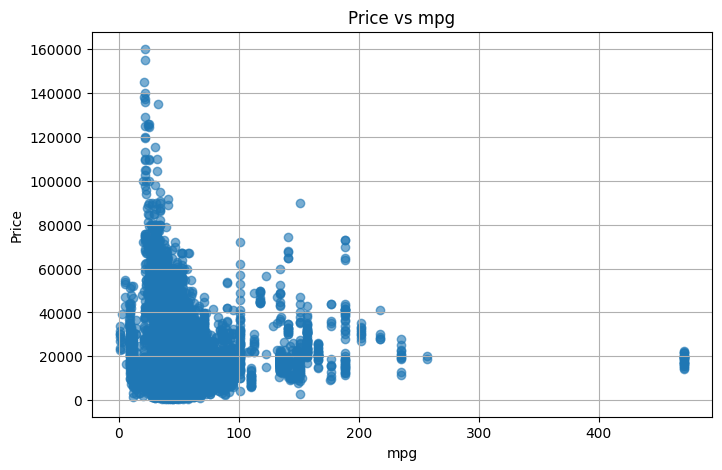

In [385]:
plt.figure(figsize=(8,5))
plt.scatter(df['mpg'], df['price'], alpha=0.6)
plt.title('Price vs mpg')
plt.xlabel('mpg')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [386]:
# --- Check strange combinations between price and mpg ---
print("\nCars with extremely high mpg but very low price:")
display(df[(df["mpg"] > 300) & (df["price"] < 25000)])


Cars with extremely high mpg but very low price:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4101,13075,bmw,i3,2015,automatic,33931,hybrid,0.0,470.8,1.7,31,4,15498
5278,12640,bmw,i3,2017,automatic,23956,other,135.0,470.8,1.1,53,1,19500
6978,12786,bmw,i3,2015,automatic,29465,electric,0.0,470.8,3.8,67,2,17400
18261,8993,bmw,i3,2016,automatic,9990,hybrid,0.0,470.8,1.5,44,0,18999
18710,12853,bmw,i3,2017,automatic,10839,hybrid,0.0,470.8,1.6,31,4,21898
21445,12090,bmw,i3,2016,automatic,8421,hybrid,0.0,470.8,1.4,31,4,19490
24975,13378,bmw,i3,2015,automatic,9886,hybrid,0.0,470.8,1.3,44,0,17481
29581,12269,bmw,i3,2017,automatic,26965,hybrid,140.0,470.8,1.7,81,3,19980
33383,10695,bmw,i3,2017,automatic,23599,hybrid,135.0,470.8,1.3,54,1,21494
33829,11532,bmw,i3,2016,automatic,35446,hybrid,0.0,470.8,1.8,59,3,16500


**Price vs mpg**
- Cars with extremely high mpg but very low price are all from the same car model, so we will keep it as it can be unique for car model

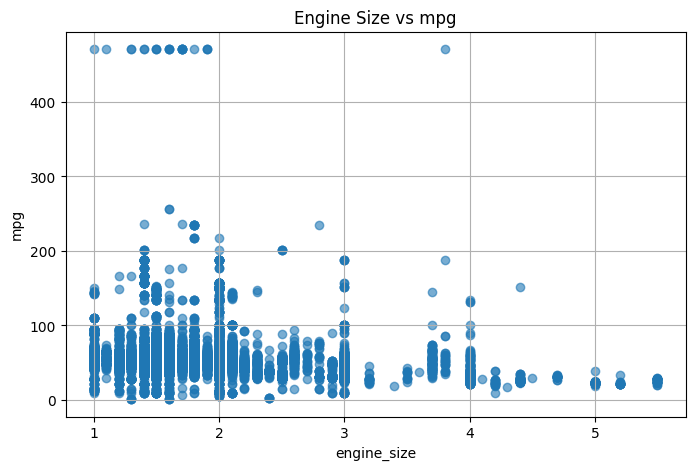

In [387]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['mpg'], alpha=0.6)
plt.title('Engine Size vs mpg')
plt.xlabel('engine_size')
plt.ylabel('mpg')
plt.grid(True)
plt.show()

**Engine Size vs mpg**
- Cars with high engine size tend to have lower mpg, which is expected
- However, there are some outliers with high engine size and high mpg, which is not expected

In [388]:
# remove entries where engine size is above 3 and mpg is above 300
df = df[~((df['engine_size'] > 3) & (df['mpg'] > 300))]


### **Boxplots**

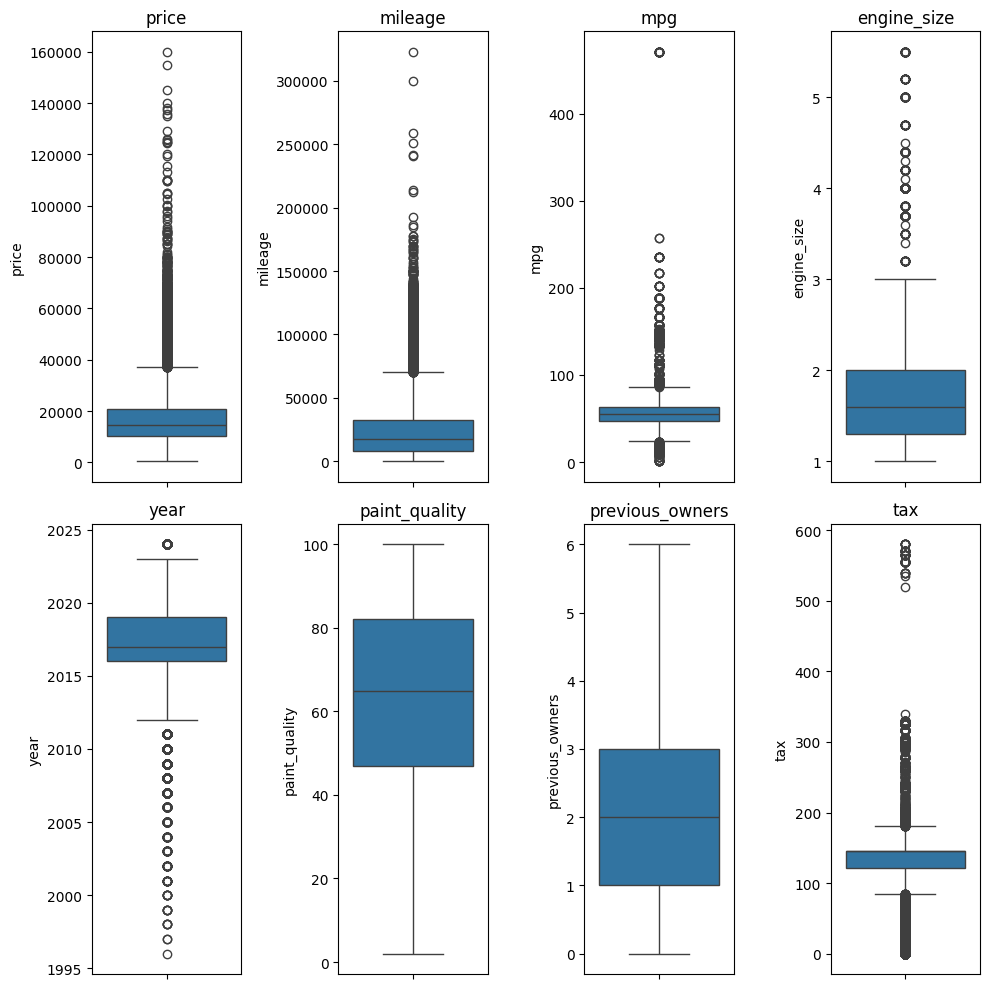

In [389]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()  # makes it a 1D array of length 6

sns.boxplot(df["price"], ax=axes[0])
axes[0].set_title("price")

sns.boxplot(df["mileage"], ax=axes[1])
axes[1].set_title("mileage")

sns.boxplot(df["mpg"], ax=axes[2])
axes[2].set_title("mpg")

sns.boxplot(df["engine_size"], ax=axes[3])
axes[3].set_title("engine_size")

sns.boxplot(df["year"], ax=axes[4])
axes[4].set_title("year")

sns.boxplot(df["paint_quality"], ax=axes[5])
axes[5].set_title("paint_quality")

sns.boxplot(df["previous_owners"], ax=axes[6])
axes[6].set_title("previous_owners")

sns.boxplot(df["tax"], ax=axes[7])
axes[7].set_title("tax")

plt.tight_layout()
plt.show()

---

## **Feature Engineering**

### **Feature Enrichment**

we have an idea to extract the horsepower and the number of gears from the external dataset. we will do that in the final delivery if so  
https://sesjournal.org/index.php/1/article/view/104/724

### **Feature Selection - Categorical**

for the feature selection, we will first make an analysis for the categorical classes and check if we have any categorical feature where the average price is more or less the same for every class. After, we will check the correlation heatmap to see if we have any redundant feature and lastly we will perform some feature elimination methods. Based on each steps results, we will decide which features to keep for the model.


C:\Users\vehnie\AppData\Local\Temp\ipykernel_8392\2478026143.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


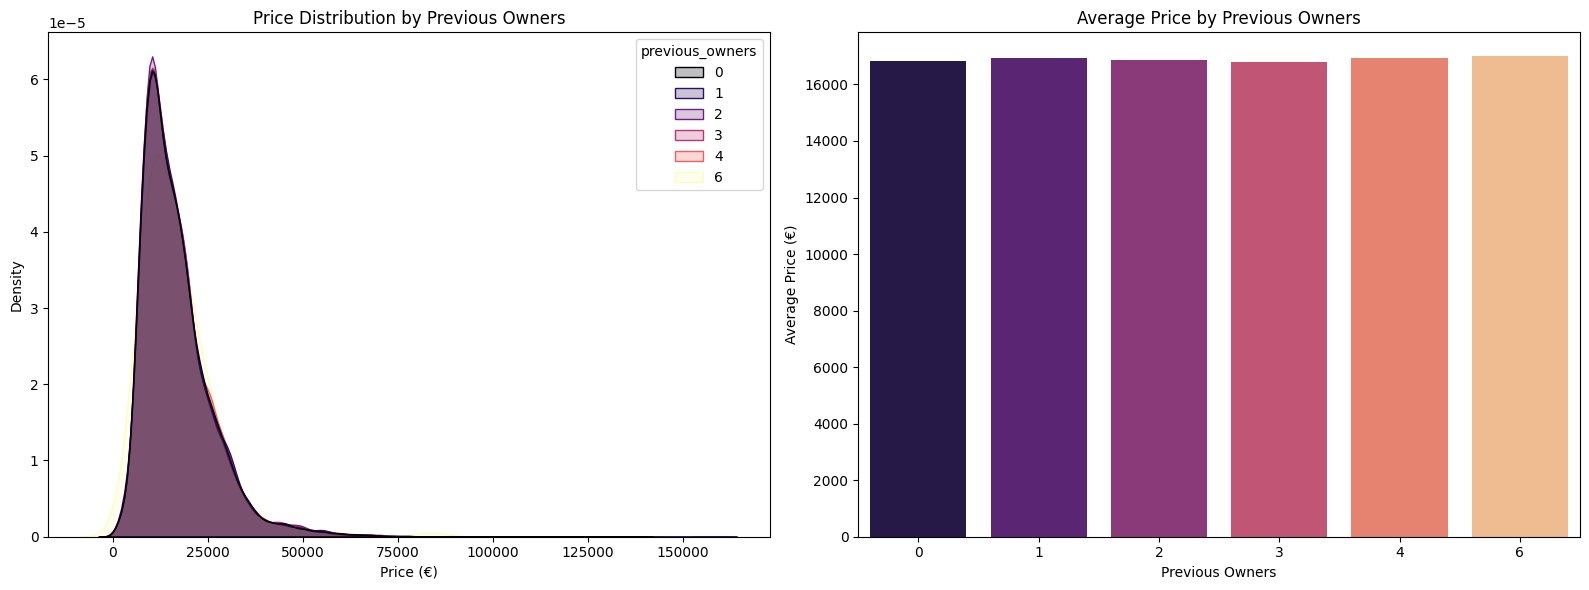

In [390]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Left: KDE plot ---
sns.kdeplot(
    data=df,
    x='price',
    hue='previous_owners',
    palette="magma",
    fill=True,
    common_norm=False,
    ax=axes[0]
)
axes[0].set_title("Price Distribution by Previous Owners")
axes[0].set_xlabel("Price (€)")
axes[0].set_ylabel("Density")

# --- Right: Average price bar plot ---
avg_price = df.groupby('previous_owners')['price'].mean().sort_index()
sns.barplot(
    x=avg_price.index,
    y=avg_price.values,
    palette="magma",
    ax=axes[1]
)
axes[1].set_title("Average Price by Previous Owners")
axes[1].set_xlabel("Previous Owners")
axes[1].set_ylabel("Average Price (€)")

plt.tight_layout()
plt.show()

The average price remains almost constant across different numbers of previous owners, indicating that ownership history has little to no direct impact on price.  
For that reason we will probably drop this feature from our df

C:\Users\vehnie\AppData\Local\Temp\ipykernel_8392\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
C:\Users\vehnie\AppData\Local\Temp\ipykernel_8392\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
C:\Users\vehnie\AppData\Local\Temp\ipykernel_8392\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes

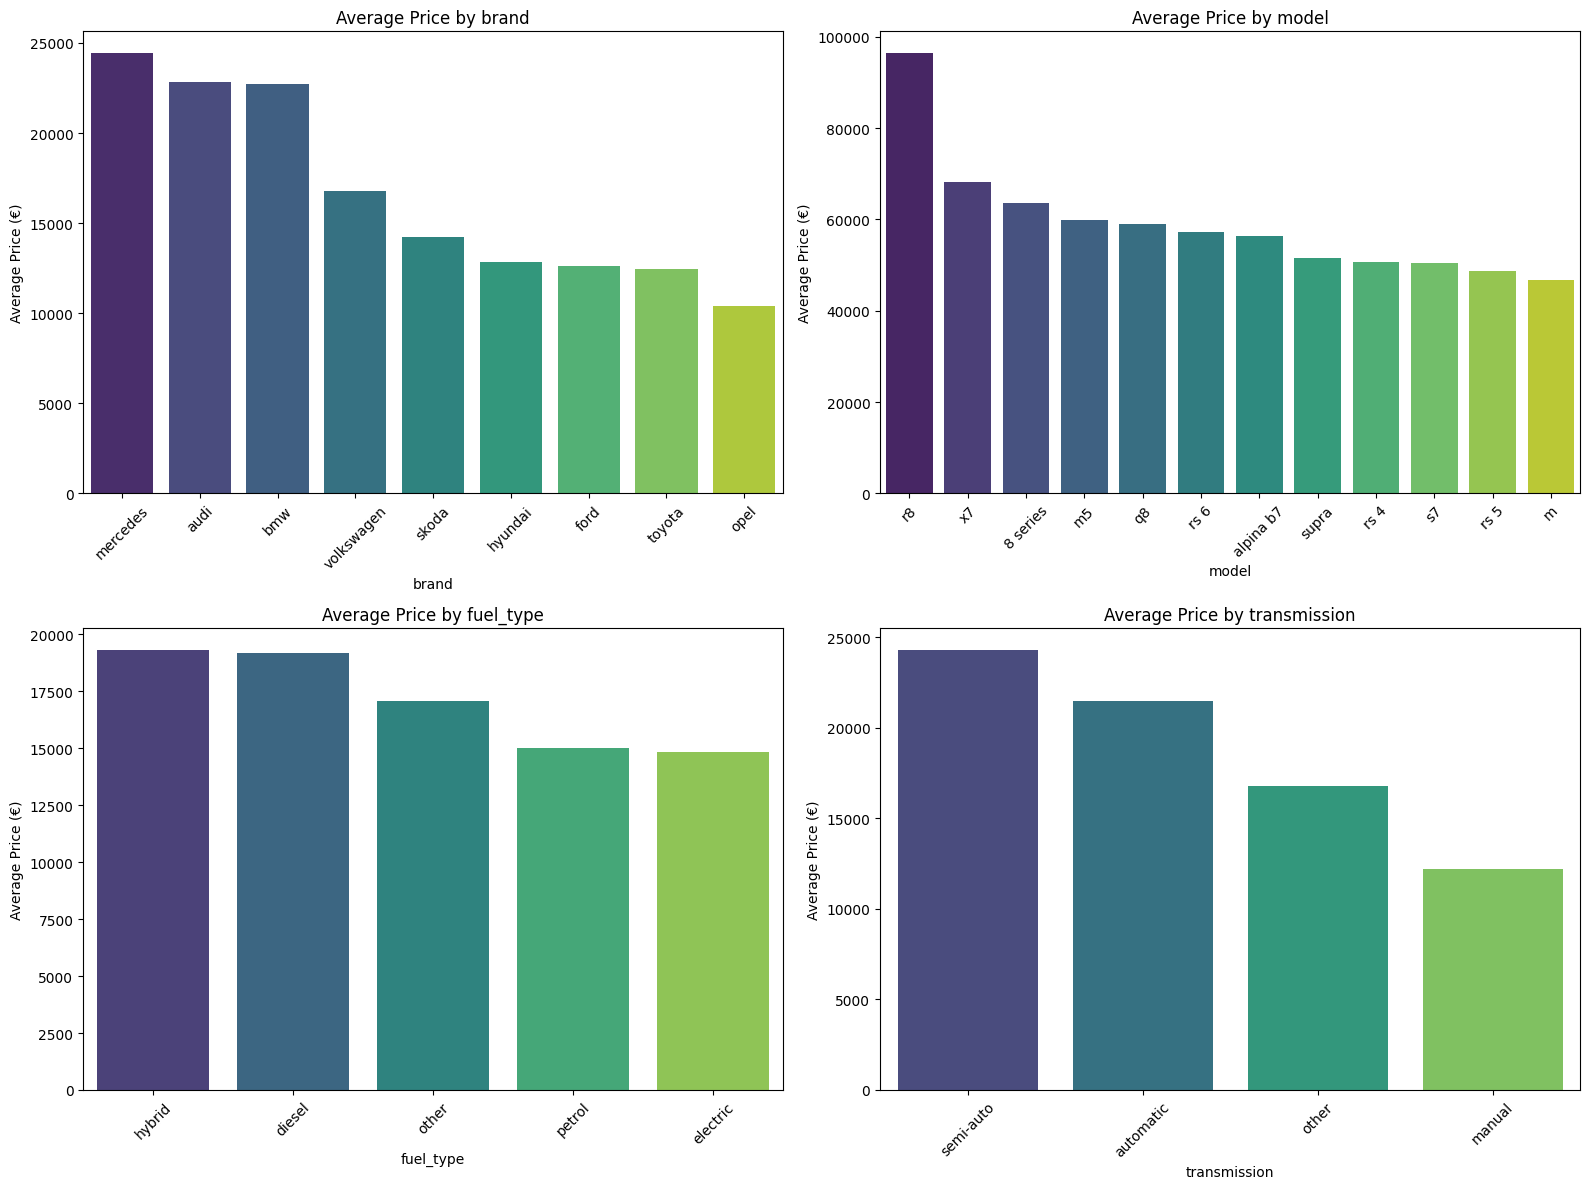

In [391]:
cat_cols = [c for c in ['brand','model','fuel_type','transmission'] if c in df.columns]
TOP_N = 12

fig, axes = plt.subplots(2, 2, figsize=(16,12))  # 2 rows, 2 cols
axes = axes.flatten()  # make it 1D for easy indexing

for i, col in enumerate(cat_cols):
    # Calculate the average price per category and select the top N
    avg_price = df.groupby(col)['price'].mean().sort_values(ascending=False).head(TOP_N)
    
    sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Average Price by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Average Price (€)")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

all the other categorical features have a clear impact on the price, since we have some difference in the average price for each category.

#### **Correlation Heatmap**

In [392]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

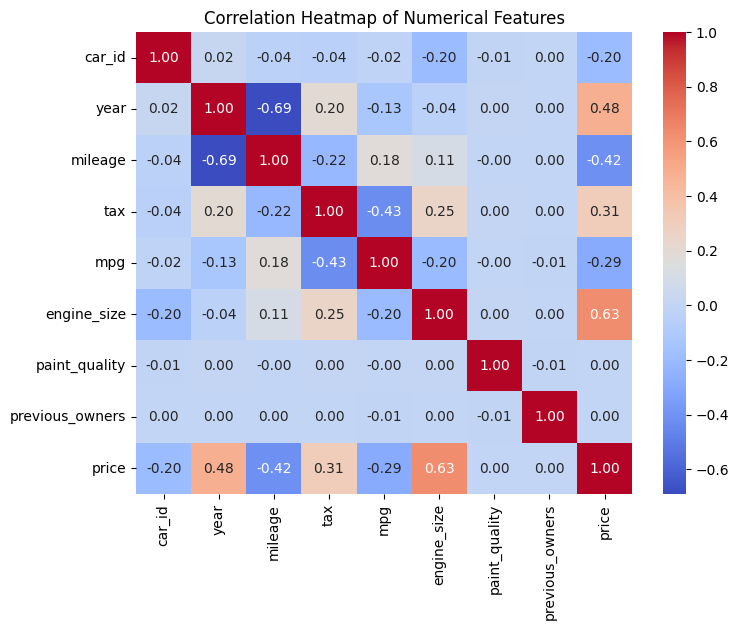

In [393]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

There are no redundant features in the dataset.  
Paint Quality and Previous Owners dont have any correlation with the price, we will remove them from the dataset.  
For now, we will remove previous_owners from the dataset.  
We will perform some more tests for the paint quality.

In [394]:
# categorical variables
df_cat= df[['brand','model','transmission','fuel_type', 'previous_owners']]

In [395]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

for var in df_cat:
    TestIndependence(df_cat[var],df['price'], var)

brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuel_type is NOT an important predictor. (Discard fuel_type from model)
previous_owners is NOT an important predictor. (Discard previous_owners from model)


### Categorical Data

| Predictor | Chi-Square | Visual Inspect | Decision |
| --- | --- | --- | --- |
| brand | Keep | Keep | Keep |
| model | Keep | Keep | Keep | 
| transmission | Keep | Keep | Keep |
| fuel_type | Discard | Keep | Keep | 
| previous_owners | Discard | Discard | Discard | 


In [396]:
df.drop(columns=['previous_owners'], inplace=True)

#### **feature manipulation**

as we said earlier, we will merge the 'electric' and 'hybrid' fuel types to 'other' fuel type, since they are not that common

In [397]:
# merge 'eletric' and 'hybrid' fuel types to 'other' fuel type
df['fuel_type'] = df['fuel_type'].replace(['electric', 'hybrid'], 'other')

we will also turn the year into age of the car, for convenience

In [398]:
# turn year into age of the car using datetime
df['age'] = datetime.now().year - df['year']
df.drop('year', axis=1, inplace=True)

and we will set the 'other' values in transmission to NaN and fill it again with the RFC model.

In [399]:
# set 'other' as NaN values in transmission
df['transmission'] = df['transmission'].replace('other', np.nan)

# fill NaN values in transmission with the RFC model
df, rfc_model, columns = train_impute_rfc(df, target_col='transmission', ignore_cols=['car_id', 'price'])

Train: Imputed 'transmission' with 753 missing values


---

## **Encoding**

**fuel_type (5 categories)** → One-Hot Encoding (OHE)

**brand (9 categories)** → One-Hot Encoding (OHE)

**transmission (4 categories)** → One-Hot Encoding (OHE)

**model (10 + categories)** → Target Encoding with K-Fold (pre defined)

In [400]:
def save_avg_prices(df, path='../data/avg_price_brand_model.csv'):

    avg_price_lookup = (
        df.groupby(['brand', 'model'])['price']
        .mean()
        .reset_index()
        .rename(columns={'price': 'avg_price'})
    )

    avg_price_lookup.to_csv(path, index=False)
    return avg_price_lookup

avg_prices = save_avg_prices(df, '../data/avg_model_prices.csv')

In [401]:
def encode_train(
    df,
    cat_cols=['brand','fuel_type','transmission'],
    avg_price_path='../data/avg_model_prices.csv',
    ohe_cols_path='assets/train_ohe_cols.joblib'
):
    # --- Média de preço antes do encoding ---
    avg_price_lookup = df.groupby(['brand','model'])['price'].mean().reset_index()
    avg_price_lookup.rename(columns={'price':'avg_price'}, inplace=True)
    avg_price_lookup.to_csv(avg_price_path, index=False)

    # Merge média
    df = df.merge(avg_price_lookup, on=['brand','model'], how='left')

    # --- One-hot encoding ---
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False, dtype=int)

    # ⚠️ Remover 'model' apenas (as outras já saíram no get_dummies)
    if 'model' in df_encoded.columns:
        df_encoded.drop(columns=['model'], inplace=True)

    # Guardar colunas resultantes
    dump(df_encoded.columns.tolist(), ohe_cols_path)

    return df_encoded

## **Split and Normalize**

In [402]:
def preprocess_df(df, test_size=0.2, rseed=42):
    """
    Split, encode e normaliza. Mantém consistência treino/val.
    """
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import pandas as pd

    # --- Split target ---
    y = df["price"]
    X = df.drop("price", axis=1)

    # --- Stratified split por bins de preço ---
    y_bins = pd.qcut(y, q=10, duplicates="drop")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=rseed,
        stratify=y_bins,
        shuffle=True
    )

    # --- Encoding (fit só no treino) ---
    train_df = X_train.copy()
    train_df["price"] = y_train
    val_df = X_val.copy()
    val_df["price"] = y_val

    train_encoded = encode_train(train_df)
    val_encoded = encode_train(val_df)

    # --- Separar features/target ---
    X_train = train_encoded.drop("price", axis=1)
    y_train = train_encoded["price"]
    X_val = val_encoded.drop("price", axis=1)
    y_val = val_encoded["price"]

    # --- Scale features numéricas ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )

    return X_train_scaled, X_val_scaled, y_train, y_val, scaler


In [403]:
X_train, X_val, y_train, y_val, scaler = preprocess_df(df)

In [404]:
cols_numerical = ['mileage', 'mpg', 'engine_size', 'age', 'avg_price', 'tax', 'paint_quality']


---

## **Feature Selection - Numerical**

### **Mutual Information**

In [405]:
mi = mutual_info_regression(X_train[cols_numerical], y_train)
pd.Series(mi, index=cols_numerical).sort_values(ascending=False)


avg_price        0.721904
engine_size      0.384127
mpg              0.377510
age              0.337007
mileage          0.322609
tax              0.206143
paint_quality    0.000133
dtype: float64

### **LassoCV** 

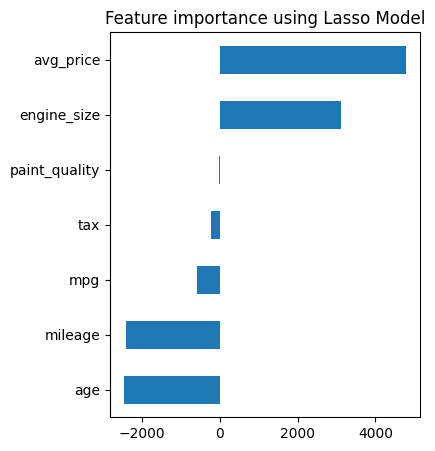

In [406]:
reg = LassoCV()

reg.fit(X_train[cols_numerical], y_train)

coef = pd.Series(reg.coef_, index = X_train[cols_numerical].columns)
coef.sort_values()
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(4,5))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
plot_importance(coef,'Lasso')



### Numerical Data

| Predictor | MI | Lasso | What to do?| 
| --- | --- | --- | --- |
| engine_size | Keep | Keep  | Keep |
| paint_quality | Discard |Discard | Discard |
| tax | Keep?| Discard | Discard |
| mpg | Keep | Keep? | Keep |
| mileage | Keep | Keep | Keep |
| age | Keep | Keep | Keep |


In [407]:
df.drop(columns=['paint_quality', 'tax', 'car_id'], inplace=True)

In [408]:
#df.to_csv('df_train.csv')

---

In [409]:
X_train, X_val, y_train, y_val, scaler = preprocess_df(df)